In [1]:
### Imports: from Python 3.7
from __future__ import print_function, division

### Imports: pandas', 'numpy'
import pandas as pd
import numpy as np

### Imports: 'statsmodels'
import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels import multivariate

### Imports: Date-related libraries 'datetime', 'calendar'
import datetime as dt
import dateutil
import copy

### Imports: Plotting libraries 'matplotlib' & 'seaborn'
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn.apionly as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# this allows plots to appear directly in the notebook
%matplotlib inline

F:\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
F:\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
F:\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
F:\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
F:\anaconda\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = oth

In [2]:
### Import 'arch'
import arch
from arch import arch_model
print (arch.__version__)
import statsmodels.tsa.statespace.sarimax as sarima
import statsmodels.graphics.tsaplots as tsplt

4.8.1


## Exploratory Analysis

In [3]:
'''
data cleaning
'''
data = pd.read_csv('crime.csv',encoding = 'cp1252')
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,0,9/2/18 13:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,0,8/21/18 0:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,0,9/3/18 19:27,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,0,9/3/18 21:16,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,0,9/3/18 21:05,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


(735964.0, 736695.0)

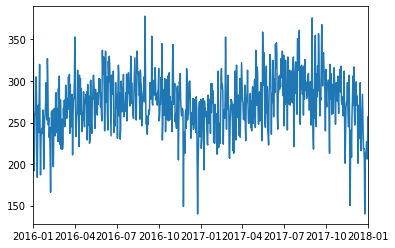

In [4]:
## Make up time columns
time = data['OCCURRED_ON_DATE']
data.index = pd.to_datetime(time,format = '%m/%d/%y %H:%M')

'''
create a univariate time series for analysis
'''
data['happen'] = np.ones(len(data))
crime = data['happen']
### resample and count event number
crime_no = crime.resample('d').sum()

'''
exploratary analysis
'''
plt.plot(crime_no)
plt.xlim(['2016','2018'])

count    1148.000000
mean      271.369512
std        15.504405
min       229.033333
25%       260.033333
50%       271.316667
75%       283.133333
max       302.900000
Name: happen, dtype: float64

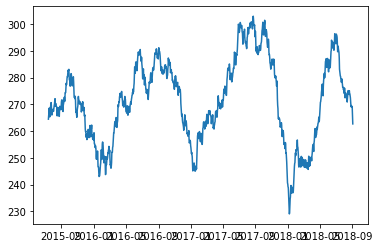

In [5]:
plt.plot(crime_no.rolling(30).mean())
monthly = crime_no.rolling(30).mean()
monthly.describe()

In [6]:
'''
FFT is not very useful for this data set, may be much better for 'natural data'
'''
def draw_fft(time_series,time_step = 1.0):
    '''
    plot fourior transform: A( amptitude ) vs T ( period )
    '''
    ts = time_series.dropna()
    fft = np.fft.rfft(monthly.dropna())
    fft = abs(fft)
    plt.plot(1.0/np.fft.fftfreq(len(ts),time_step)[:(len(fft)-1)],fft[1:])
    print(np.fft.fftfreq(len(ts)))
    print(len(fft[1:]))

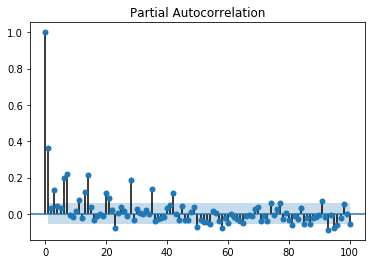

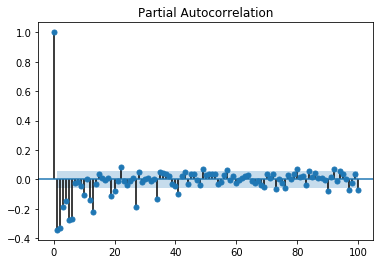

In [7]:

#figure = tsplt.plot_acf(crime_no.values.squeeze(),lags = 400)
#figure2 = tsplt.plot_acf(crime_no.values.squeeze(),lags = 8)
#figure3 = tsplt.plot_pacf(crime_no.values.squeeze(),lags = 400)
figure4 = tsplt.plot_pacf(crime_no.values.squeeze(),lags = 100)
#figure4 = tsplt.plot_pacf(crime_no.values.squeeze(),lags = 8)
de_season = crime_no.diff(1).dropna()
#print(de_season)
figure4 = tsplt.plot_pacf(de_season.values.squeeze(),lags = 100)

### Assume only constant: DF test

In [8]:
'''
Dicky Fuller test
regression{‘c’,’ct’,’ctt’,’nc’}
autolag{‘AIC’, ‘BIC’, ‘t-stat’, None}
'''
df_test = sm.tsa.stattools.adfuller(monthly.dropna(), maxlag=None, regression='c', autolag='AIC', store=True, regresults=True)
print('adf_stat: ',df_test[0] )
print('p-value:',df_test[1])
print(df_test[2])

adf_stat:  -2.5965495252285686
p-value: 0.09371250952267202
{'1%': -3.4361812251221555, '5%': -2.864114820815637, '10%': -2.5681409066817795}


### Assume trend + constant: DF test

In [9]:
df_test = sm.tsa.stattools.adfuller(monthly.dropna(), maxlag=None, regression='c', autolag='AIC', store=True, regresults=True)
print('adf_stat: ',df_test[0] )
print('p-value:',df_test[1])
print(df_test[2])

adf_stat:  -2.5965495252285686
p-value: 0.09371250952267202
{'1%': -3.4361812251221555, '5%': -2.864114820815637, '10%': -2.5681409066817795}


## SARIMA 

In [10]:
def My_SARIMAX(endog = monthly, exog=None ,order=(2,0,1),seasonal_order=(2,0,1,7),maxlag = 70):
    '''
    SARIMAX
    input: 
    endog: time series, 1D
    order: (p,d,q) arma
    seasonal order: (P,D,Q,S), P,D,Q: seasonal order; S: seasonal period, usually monthly-12, daily-7
    S too big would seriously slow down estimation, use exog as alternative
    '''
    x = sarima.SARIMAX(endog = endog,exog = exog,order=(2,0,1),seasonal_order=(2,0,0,7),enforce_invertibility = False,enforce_stationarity =False)
    y = x.fit()
    P,D,Q,S = seasonal_order
    p,d,q = order
    
    ### print point estimates
    point_estimate = pd.DataFrame({'estimates':y.params,'t_values':y.tvalues})
    print('coefficients:\n',point_estimate)
    
    ### print fitted values
    combined = pd.DataFrame({'original':monthly,'predict':y.predict()})
    plotdf = combined.dropna()[P*S+p:]
    figure1 = plt.figure()
    for name in plotdf.columns:
        plt.plot(plotdf[name],label = name)
    plt.legend()
    plt.title('Predicted vs Real value')
    plt.xlim(['2016','2017'])
    #### model analysis: residual analysis, first step estimation is problematic
    residual = y.resid.dropna()[P*S+p:]
    resid_lj = sm.stats.diagnostic.acorr_ljungbox(residual)
    
    #### pvalues of different laggs
    resid_pvalues = resid_lj[1]
    figure_pvalues = plt.figure()
    plt.plot(resid_lj[1],'o-')
    plt.title('Ljung-Box Test of residuals')
    
    #### acf & pacf of residual
    print('Test for autocorrelation:')
    acf_figure = plt.figure()
    tsplt.plot_acf(residual,lags = maxlag)
    pacf_figure = plt.figure()
    tsplt.plot_pacf(residual,lags = maxlag)
    res_figure = plt.figure()
    resid_figure = plt.plot(residual[:100],'o-')
    plt.title('residual sample')
    
    ### Heteroskedascity
    print('Test for heteroskedascity:')
    acf_figure = plt.figure()
    tsplt.plot_acf(residual**2,lags = maxlag)
    pacf_figure = plt.figure()
    tsplt.plot_pacf(residual**2,lags = maxlag)
    res_figure = plt.figure()
    return y

coefficients:
           estimates   t_values
ar.L1      1.650343  22.757442
ar.L2     -0.679549  -9.816991
ma.L1     -0.503402  -5.898905
ar.S.L7    0.507268  19.491339
ar.S.L14   0.489731  18.908167
sigma2     2.092322  24.641258
Test for autocorrelation:
Test for heteroskedascity:


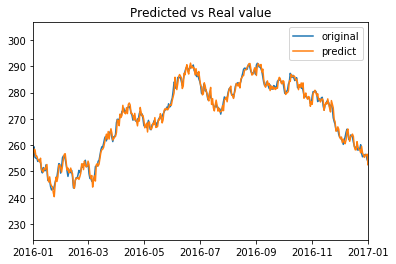

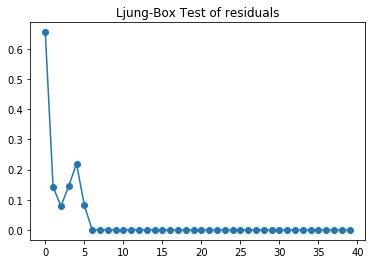

<Figure size 432x288 with 0 Axes>

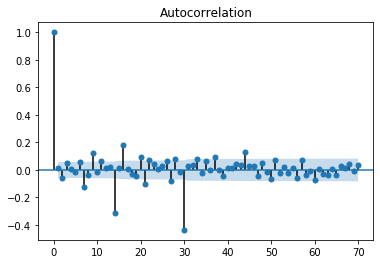

<Figure size 432x288 with 0 Axes>

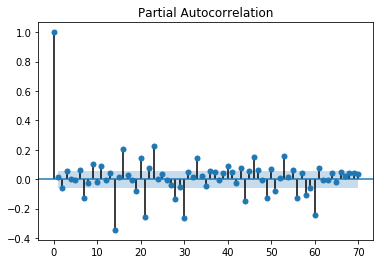

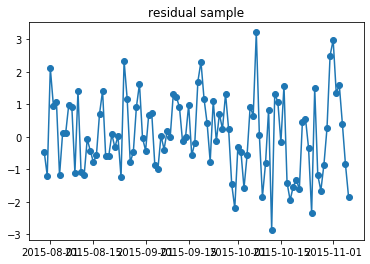

<Figure size 432x288 with 0 Axes>

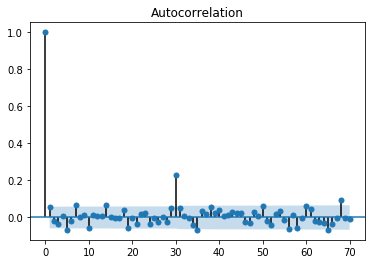

<Figure size 432x288 with 0 Axes>

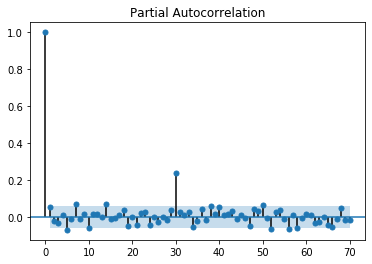

<Figure size 432x288 with 0 Axes>

In [11]:
'''
seasonal, no exog, use a first difference
'''
My_SARIMAX(endog = monthly.dropna(), exog=None ,order=(2,1,1),seasonal_order=(2,0,1,7),maxlag = 70)

coefficients:
           estimates   t_values
ar.L1      1.650343  22.757442
ar.L2     -0.679549  -9.816991
ma.L1     -0.503402  -5.898905
ar.S.L7    0.507268  19.491339
ar.S.L14   0.489731  18.908167
sigma2     2.092322  24.641258
Test for autocorrelation:
Test for heteroskedascity:


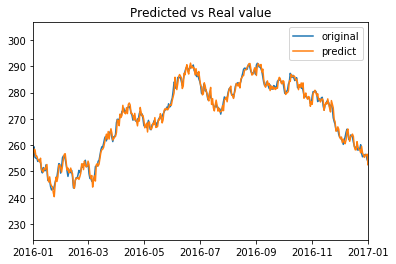

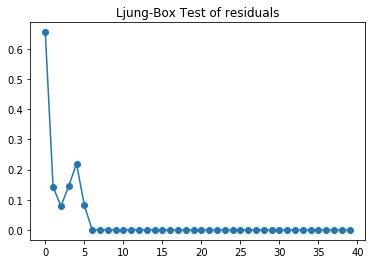

<Figure size 432x288 with 0 Axes>

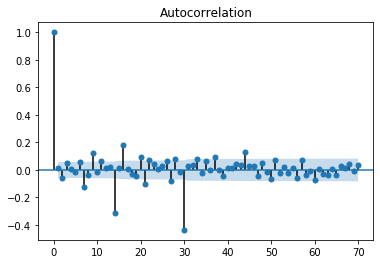

<Figure size 432x288 with 0 Axes>

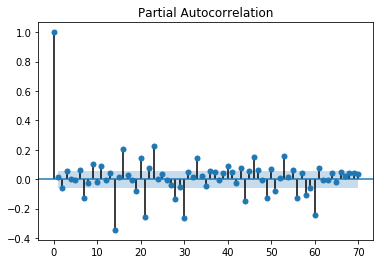

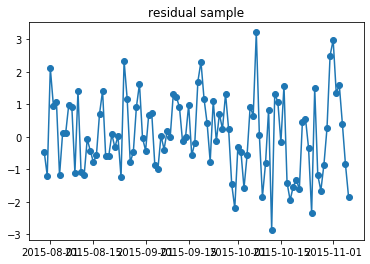

<Figure size 432x288 with 0 Axes>

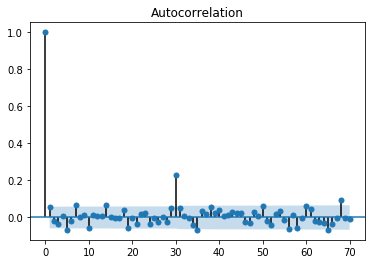

<Figure size 432x288 with 0 Axes>

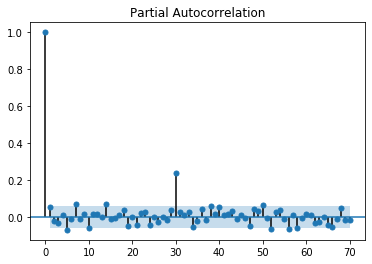

<Figure size 432x288 with 0 Axes>

In [12]:
'''
seasonal, no exog, use no first difference
'''
My_SARIMAX(endog = monthly.dropna(), exog=None ,order=(2,0,1),seasonal_order=(2,0,1,7),maxlag = 70)

F:\anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


coefficients:
            estimates   t_values
x1        270.305387   0.122560
x2        271.521571   0.122042
x3        271.769022   0.123510
x4        271.822266   0.124345
x5        272.174419   0.124638
x6        271.810460   0.124380
ar.L1       0.148739   0.637928
ar.L2       0.742161   3.338595
ma.L1       1.215014   3.722130
ar.S.L7     0.498138  15.900633
ar.S.L14    0.501481  16.056396
sigma2      1.676762   1.846996
Test for autocorrelation:
Test for heteroskedascity:


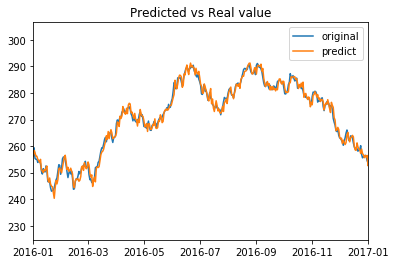

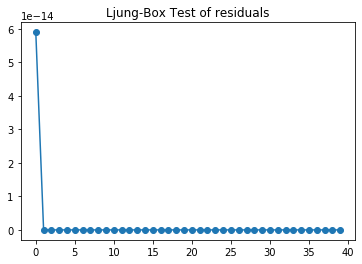

<Figure size 432x288 with 0 Axes>

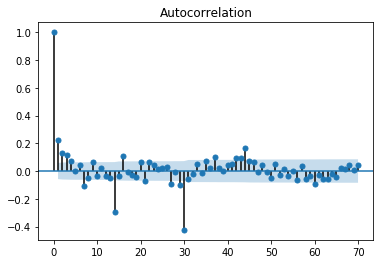

<Figure size 432x288 with 0 Axes>

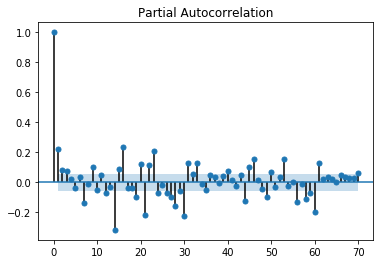

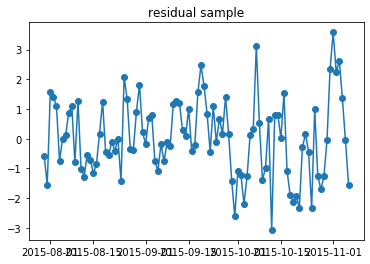

<Figure size 432x288 with 0 Axes>

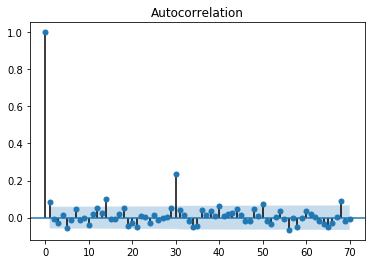

<Figure size 432x288 with 0 Axes>

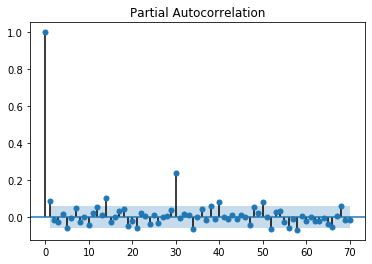

<Figure size 432x288 with 0 Axes>

In [13]:
'''
Add weekday dummy
'''
is_weekend = np.array([monthly.dropna().index.dayofweek == i for i in range(6)])*1.0
#### starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6
y = My_SARIMAX(endog = monthly.dropna(), exog=is_weekend.T  ,order=(2,0,1),seasonal_order=(2,0,1,7),maxlag = 70)

### The results suggest monthly component affecting result
## Now we turn to daily data which is much more volatile

coefficients:
            estimates   t_values
x1        270.279181   4.087105
x2        276.088883   3.542615
x3        278.148850   3.622957
x4        277.712694   4.454573
x5        288.660386   4.227870
x6        266.763743   3.595067
ar.L1      -0.444039  -0.765172
ar.L2       0.142653   1.178443
ma.L1       0.652368   1.123024
ar.S.L7     0.467043  20.709028
ar.S.L14    0.497420  22.133564
sigma2    992.657493  27.808102
Test for autocorrelation:
Test for heteroskedascity:


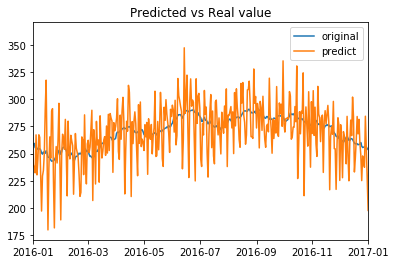

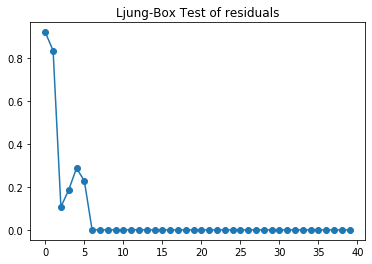

<Figure size 432x288 with 0 Axes>

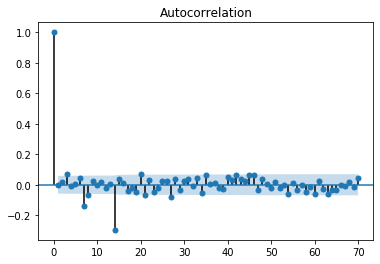

<Figure size 432x288 with 0 Axes>

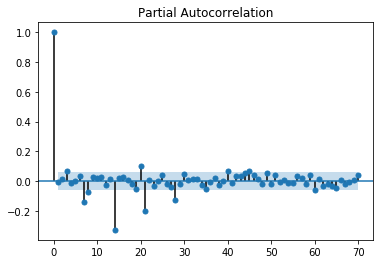

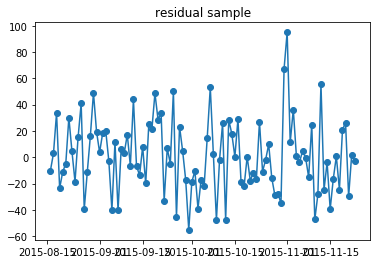

<Figure size 432x288 with 0 Axes>

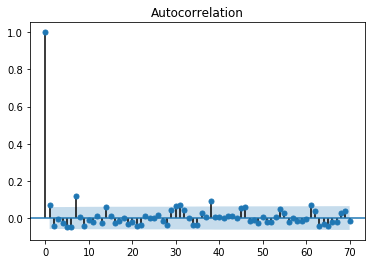

<Figure size 432x288 with 0 Axes>

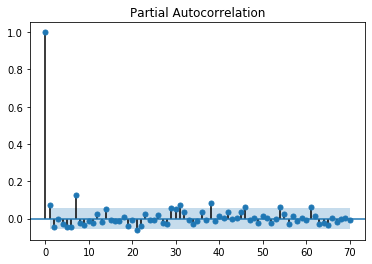

<Figure size 432x288 with 0 Axes>

In [14]:
'''
weekday dummy + monthly seasonal effect
'''
daily = crime_no.resample('d').sum()
is_weekend = np.array([crime_no.dropna().index.dayofweek == i for i in range(6)])*1.0
#### starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6
y = My_SARIMAX(endog = crime_no.dropna(), exog=is_weekend.T  ,order=(2,0,1),seasonal_order=(2,0,1,30),maxlag = 70)

coefficients:
             estimates    t_values
ar.L1        1.242511   32.130204
ar.L2       -0.242527   -6.272632
ma.L1       -1.017797 -155.778996
ar.S.L7      0.184632    4.800153
ar.S.L14     0.224768    5.614481
sigma2    1093.891459   19.054021
Test for autocorrelation:
Test for heteroskedascity:


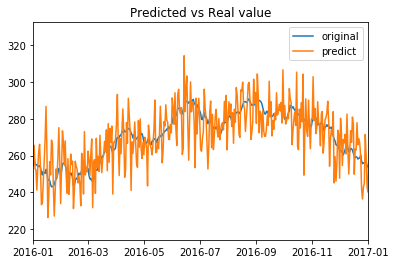

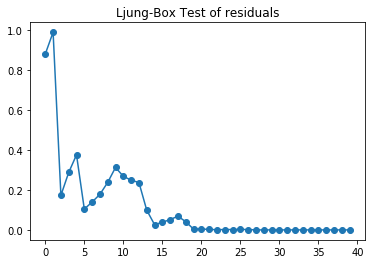

<Figure size 432x288 with 0 Axes>

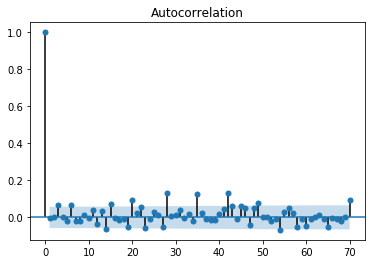

<Figure size 432x288 with 0 Axes>

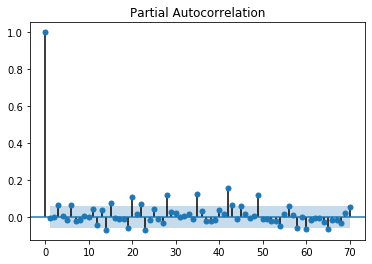

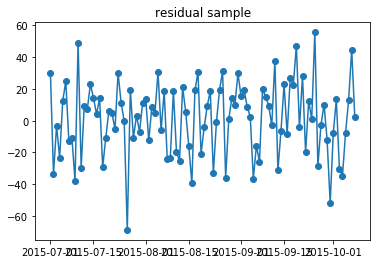

<Figure size 432x288 with 0 Axes>

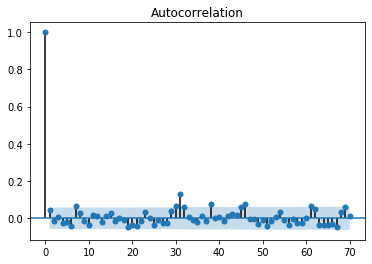

<Figure size 432x288 with 0 Axes>

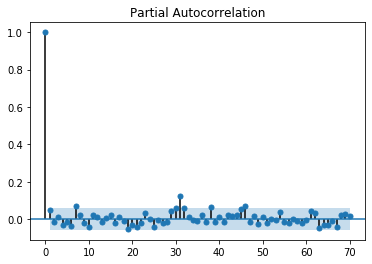

<Figure size 432x288 with 0 Axes>

In [15]:
'''
Weekly seasonal effect and no exogenous effect
'''
y = My_SARIMAX(endog = crime_no.dropna(),order=(2,0,1),seasonal_order=(2,0,1,7),maxlag = 70)

coefficients:
             estimates    t_values
ar.L1        1.242511   32.130204
ar.L2       -0.242527   -6.272632
ma.L1       -1.017797 -155.778996
ar.S.L7      0.184632    4.800153
ar.S.L14     0.224768    5.614481
sigma2    1093.891459   19.054021
Test for autocorrelation:
Test for heteroskedascity:


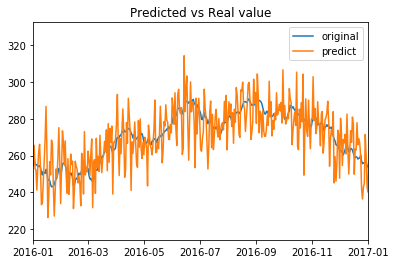

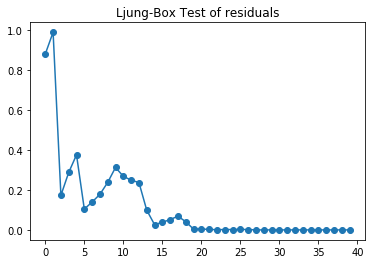

<Figure size 432x288 with 0 Axes>

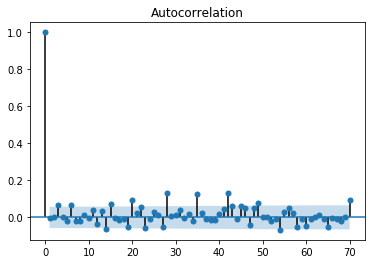

<Figure size 432x288 with 0 Axes>

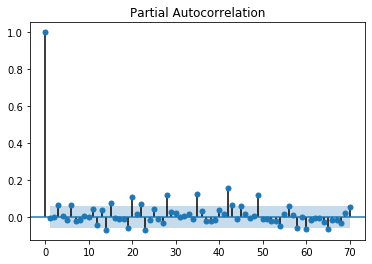

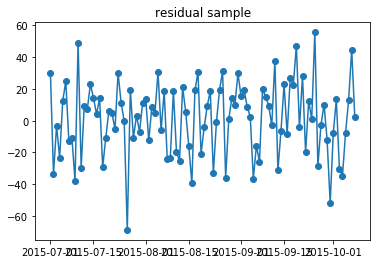

<Figure size 432x288 with 0 Axes>

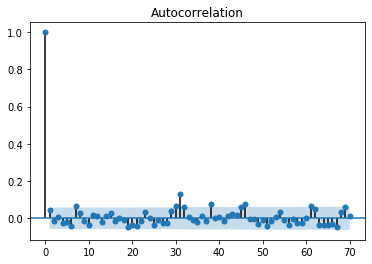

<Figure size 432x288 with 0 Axes>

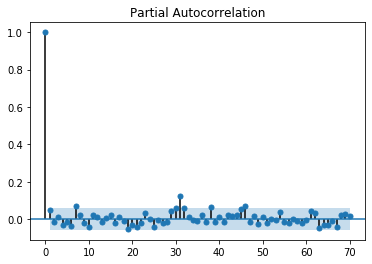

<Figure size 432x288 with 0 Axes>

In [16]:
'''
only arima
'''
y = My_SARIMAX(endog = crime_no.dropna(),order=(2,1,1),maxlag = 70)

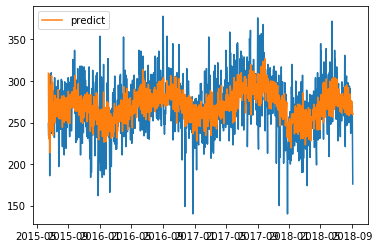

In [17]:
test = y.predict().rolling(1).mean()[1:]
plt.plot(crime_no[1:])
plt.plot(test,label = 'predict')
plt.legend()

### The predicted value looks good compared to entire series (including outliers) But bad compared to normal values
### One quick and dirty way to deal with this is transferring ARMA(p,q) into ARMA(p,q+s) through rolling s mean, while AR coefficients remain the same. Next we try s = 5

coefficients:
           estimates   t_values
ar.L1      1.281750   8.656529
ar.L2     -0.283617  -1.917374
ma.L1     -0.082289  -0.536972
ar.S.L7    0.207563   6.679032
ar.S.L14   0.251106   8.698554
sigma2    65.396296  25.101541
Test for autocorrelation:
Test for heteroskedascity:


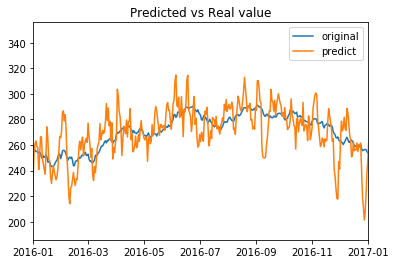

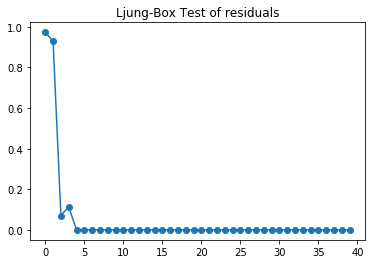

<Figure size 432x288 with 0 Axes>

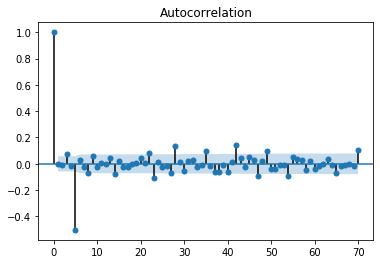

<Figure size 432x288 with 0 Axes>

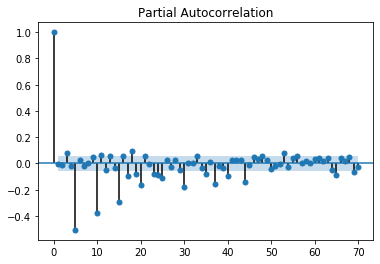

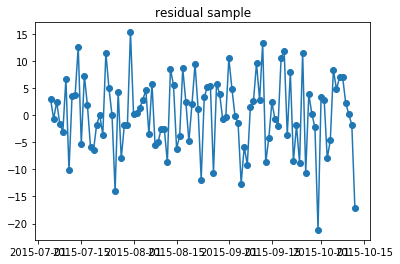

<Figure size 432x288 with 0 Axes>

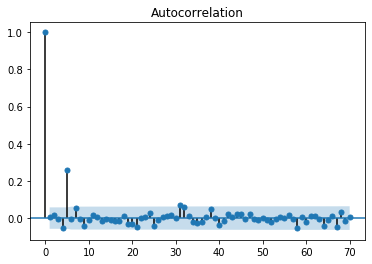

<Figure size 432x288 with 0 Axes>

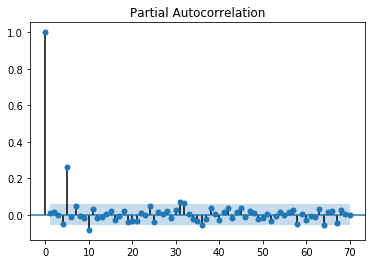

<Figure size 432x288 with 0 Axes>

In [43]:
y = My_SARIMAX(endog = crime_no.rolling(5).mean().dropna()  ,order=(2,0,5+1),seasonal_order=(2,0,1,7),maxlag = 70)

In [44]:
y.predict()

OCCURRED_ON_DATE
2015-06-19      0.000000
2015-06-20    337.100341
2015-06-21    265.585609
2015-06-22    248.754556
2015-06-23    259.505814
2015-06-24    250.739844
2015-06-25    248.995516
2015-06-26    312.781466
2015-06-27    263.740931
2015-06-28    283.339071
2015-06-29    277.838119
2015-06-30    269.936754
2015-07-01    263.605704
2015-07-02    271.424540
2015-07-03    326.724833
2015-07-04    251.187556
2015-07-05    261.176016
2015-07-06    264.653837
2015-07-07    260.755839
2015-07-08    263.324508
2015-07-09    261.047346
2015-07-10    262.670080
2015-07-11    272.561588
2015-07-12    258.370862
2015-07-13    260.639025
2015-07-14    262.937797
2015-07-15    278.505402
2015-07-16    269.479430
2015-07-17    281.761879
2015-07-18    282.447307
                 ...    
2018-08-05    278.762883
2018-08-06    266.324953
2018-08-07    275.349366
2018-08-08    265.476563
2018-08-09    247.227862
2018-08-10    268.200951
2018-08-11    280.169426
2018-08-12    267.294076
2018-08-

### Predict is problematic at the beginning of the series (lack of previous data)

## ARCH template
$r_t  =  \mu + \epsilon_t$   
$\sigma^2_t   =  \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$

Iteration:     10,   Func. Count:     81,   Neg. LLF: 4216.484500787867
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4215.865912407071
            Iterations: 17
            Function evaluations: 131
            Gradient evaluations: 17
                    Constant Mean - AVGARCH Model Results                     
Dep. Variable:                 happen   R-squared:                      -0.013
Mean Model:             Constant Mean   Adj. R-squared:                 -0.013
Vol Model:                    AVGARCH   Log-Likelihood:               -4215.87
Distribution:                  Normal   AIC:                           8441.73
Method:            Maximum Likelihood   BIC:                           8466.96
                                        No. Observations:                 1148
Date:                Sat, Sep 07 2019   Df Residuals:                     1143
Time:                        20:27:36   Df Model:                            5
      

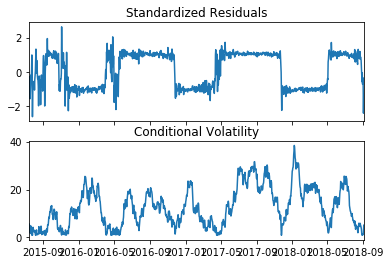

In [21]:
am = arch_model(monthly.dropna(), p=2, q=1, power=1.0)
#### p: innovation lags, q: 'AR' terms
res = am.fit(update_freq=10)
print(res.summary())
figure = res.plot()

### Interpretaion: certain outliers cause constant mean to fail completely

In [22]:
from arch.univariate import ARX
ar = ARX(monthly.dropna(), lags=[1, 7, 30])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                 happen   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:          Constant Variance   Log-Likelihood:               -2012.61
Distribution:                  Normal   AIC:                           4035.23
Method:            Maximum Likelihood   BIC:                           4060.32
                                        No. Observations:                 1118
Date:                Sat, Sep 07 2019   Df Residuals:                     1113
Time:                        20:27:37   Df Model:                            5
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          2.6685      0.855      3.121  1.800e-

                           AR - GARCH Model Results                           
Dep. Variable:                 happen   R-squared:                       0.991
Mean Model:                        AR   Adj. R-squared:                  0.991
Vol Model:                      GARCH   Log-Likelihood:               -2012.07
Distribution:                  Normal   AIC:                           4040.13
Method:            Maximum Likelihood   BIC:                           4080.29
                                        No. Observations:                 1118
Date:                Sat, Sep 07 2019   Df Residuals:                     1110
Time:                        20:27:37   Df Model:                            8
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          2.7151      0.858      3.164  1.555e-

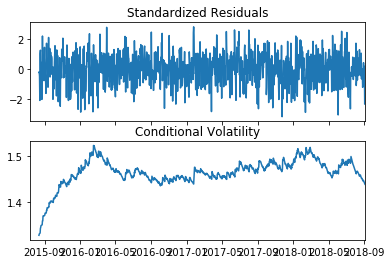

In [23]:
from arch.univariate import ARCH, GARCH
ar.volatility = GARCH(p=2, q=1)
res = ar.fit(update_freq=0, disp='off')
print(res.summary())
figure = res.plot()

### Looks much better and plausible

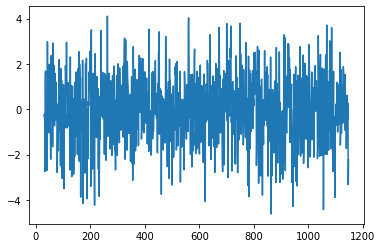

In [24]:
dir(res)
plt.plot(res._resid)

## Exploration analysis for dataframe/series data

In [25]:
def exploration(df,max_lag =  100):
    '''
    including summary statistics, acf & pacf plots
    '''
    print(df.describe())
    df = pd.DataFrame(df)
    for col_name in df.columns:
        ts = df[col_name].dropna()
        try:
            print(col_name)
            tsplt.plot_pacf(ts.values.squeeze(),lags = max_lag)
            tsplt.plot_acf(ts.values.squeeze(),lags = max_lag)
        except:
            print('error encountered for',name)

count    1177.000000
mean      271.090059
std        33.090584
min       140.000000
25%       251.000000
50%       273.000000
75%       292.000000
max       378.000000
Name: happen, dtype: float64
happen


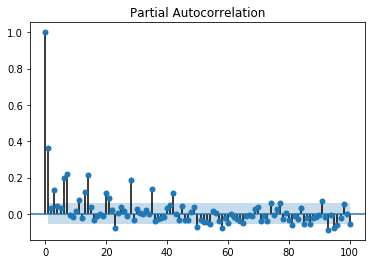

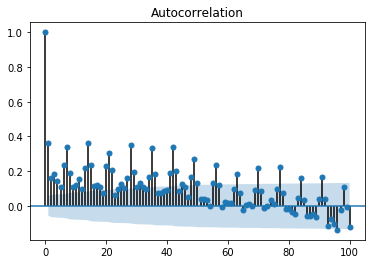

In [26]:
exploration(crime_no)

### VARMAX

### Constructing multi-dimensional time series

In [27]:
data['time'] = data.index
def time_slice(x,time_vector = [0,6,12,18,24]):
    '''
    change time x into catagorical data
    [0,6] to 0, [6,12] to 1...
    '''
    time_vector = np.array(time_vector)
    lower = x.hour >= time_vector[:-1]
    upper = x.hour < time_vector[1:]
    index = lower & upper
    #print(upper,lower)
    n = len(time_vector) - 1
    #print(index)
    return np.arange(n)[index][0]

In [28]:
data['time_period'] = data.time.apply(time_slice)

In [29]:
data.groupby('time_period').agg('count')

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,happen,time
time_period,,,,,,,,,,,,,,,,,,,
0,43376,43376,43376,43376,43065,43376,470,43376,43376,43376,43376,43376,43351,41588,40197,40197,43376,43376,43376
1,74454,74454,74454,74454,74075,74454,324,74454,74454,74454,74454,74454,74442,72277,70345,70345,74454,74454,74454
2,109870,109870,109870,109870,109268,109870,698,109870,109870,109870,109870,109870,109841,106169,103027,103027,109870,109870,109870
3,91373,91373,91373,91373,90900,91373,822,91373,91373,91373,91373,91373,91349,88168,85505,85505,91373,91373,91373


In [30]:
crime_num_period = pd.DataFrame({i:data.time_period.apply(lambda x: x == i).resample('D').sum() for i in range(4)})

(736085.0, 736146.0)

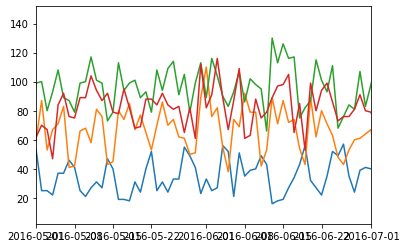

In [31]:
plt.plot(crime_num_period)
plt.xlim(['2016-5','2016-7'])

In [32]:
def plt_dataframe(df,xlim=(0,1)):
    '''
    xlim = (low_fraction, upper_fraction)
    plot df dataframe with column names as label
    '''
    for col in df.columns:
        plt.plot(df[col],label = col)
    plt.legend()
    low , high = xlim
    n = len(df.index)
    low = df.index[int(n*low)]
    high = df.index[int(n*high)-1]
    plt.xlim([low,high])

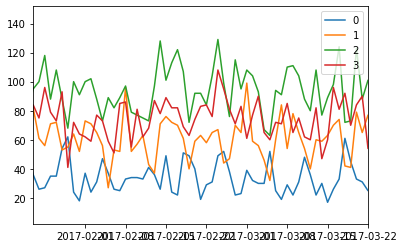

In [33]:
plt_dataframe(crime_num_period,(0.5,0.55))

## VARMAX

In [34]:
varma_model = sm.tsa.VARMAX(crime_num_period,order = (2,1))
varma_res = varma_model.fit(maxiter=1000, disp=False)
print(varma_res.summary())

F:\anaconda\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
F:\anaconda\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
F:\anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:           [0, 1, 2, 3]   No. Observations:                 1177
Model:                     VARMA(2,1)   Log Likelihood              -18452.974
                          + intercept   AIC                          37029.947
Date:                Sat, 07 Sep 2019   BIC                          37344.332
Time:                        20:28:41   HQIC                         37148.487
Sample:                    06-15-2015                                         
                         - 09-03-2018                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):          486.70, 167.62, 63.26, 47.43   Jarque-Bera (JB):   1667.03, 28.53, 10.06, 8.52
Prob(Q):                      0.00, 0.00, 0.01, 0.20   Prob(JB):                0.00, 0.00, 0.01, 0.01
Heteroskedasticity (H):       0.67, 1.15, 0.99, 0.95   Skew:                    1.1

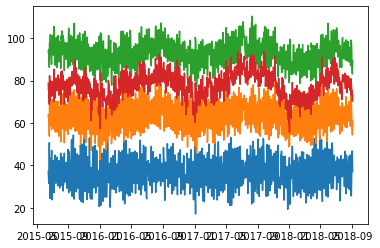

In [35]:
'''
predicted in-sample value
'''
plt.plot(varma_res.predict())

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
F:\anaconda\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


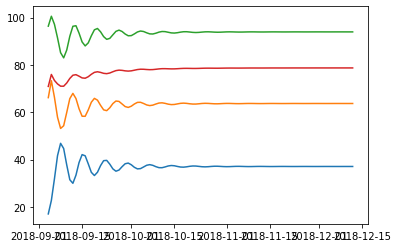

In [36]:
'''
forecasting future value
'''
plt.plot(varma_res.forecast(100))

In [37]:

from sklearn.decomposition import PCA
def pca(Y):
    '''
    input: Y dataframe of different time series
    '''
    pca_sk = PCA(n_components=len(Y.columns)).fit(Y.values)
    pca_summary = pd.DataFrame()
    name_ls = ['value', 'Difference', 'Proportion', 'Cumulative value', 'Cumulative proportion']

    pca_summary['value'] = pca_sk.explained_variance_
    pca_summary['Difference'] = pca_summary.value.diff(-1)
    pca_summary['Proportion'] = pca_sk.explained_variance_ratio_
    pca_summary['Cumulative value'] = pca_summary.value.cumsum()
    pca_summary['Cumulative Proportion'] = pca_summary.Proportion.cumsum()
    pca_summary.round(4)
    print(pca_summary)
    x = multivariate.pca.PCA(Y, standardize=False)
    return x.loadings, x.factors

In [38]:
loadings , factors = pca(crime_num_period)

        value  Difference  Proportion  Cumulative value  Cumulative Proportion
0  451.391464  278.336079    0.531170        451.391464               0.531170
1  173.055385   49.420275    0.203641        624.446848               0.734812
2  123.635109   21.911667    0.145486        748.081958               0.880298
3  101.723442         NaN    0.119702        849.805400               1.000000


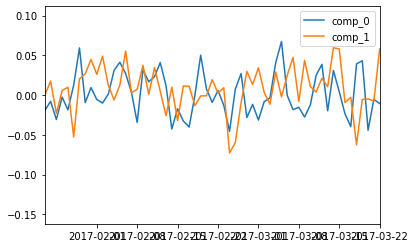

In [39]:
plt_dataframe(factors.loc[:,'comp_0':'comp_1'],(0.5,0.55))

### If we want, we can do sarima on these components